# Simulating Brain models

In [1]:
# Networks handling
import networkx as nx

# Numpy + linear algebra + fft
import numpy as np
import scipy.sparse as sparse
from scipy.fft import fft

# User-defined functions
from CriticalBrain import sample_from, GH

# Visualization 
import matplotlib.pyplot as plt
from tqdm import tqdm

We have to simulate the following cellular automata:
- I -> A with probability $r_1=10^{-3}$ or if $\sum_{j,active}W_{ij}>T$;
- A -> R always;
- R -> I with small probability $r_2=0.2$

We further identify the states with a number:
- A = $1$
- I = $0$
- R = $-1$

## Generate the system

We create a system of size $size$, all in the inactive state but for $n_a$ neurons

In [2]:
states = {0: 'Inactive', 1:'Active', -1: 'Refractory'}

size = int(1e3)
n_a = 10
system = np.zeros(size, dtype=int)

random_active = np.random.randint(0, size, n_a)
system[random_active] += 1

## Generate connectivity matrix

In [3]:
weight_cum_distr =np.loadtxt('data/WCumDistr.csv', delimiter=';')

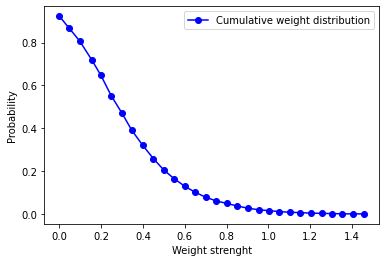

In [4]:
plt.plot(weight_cum_distr[:,0], weight_cum_distr[:, 1], 'bo-', label='Cumulative weight distribution')
plt.legend()
#plt.yscale('log')
plt.ylabel('Probability')
plt.xlabel('Weight strenght')
plt.show()

In [5]:
sample = sample_from(weight_cum_distr, 1000)

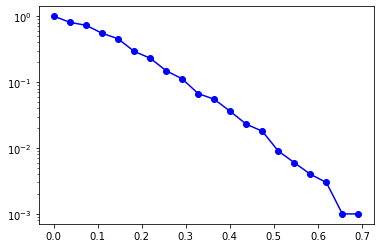

In [6]:
height, bins = np.histogram(sample, bins=20, density=True)
h = np.cumsum(height[::-1] )/height.sum()
plt.plot( (bins[:1]+bins[:-1])/2, h[::-1], 'bo-')
plt.yscale('log')

In [7]:
n = 1000 
m = 8
seed = 999
G = nx.barabasi_albert_graph(n, m, seed)
for n1, n2 in G.edges():
    G[n1][n2]['weight'] = sample_from(weight_cum_distr, 1)[0]
matrix = nx.adjacency_matrix(G)
print(f'Density: {G.number_of_edges()/G.number_of_nodes()**2}')

Density: 0.007936


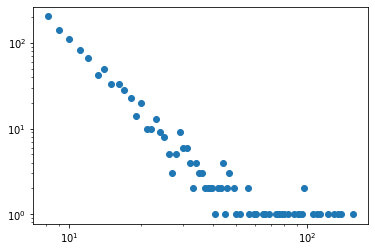

In [8]:
deg = [d for n, d in G.degree()]
h, p = np.histogram(deg, bins=500)
plt.loglog()
plt.plot((p[1:]+p[:-1])/2, h, 'o')
#plt.plot( 2e3*np.arange(1, 20).astype(float)**(-2.5)  )
plt.show()

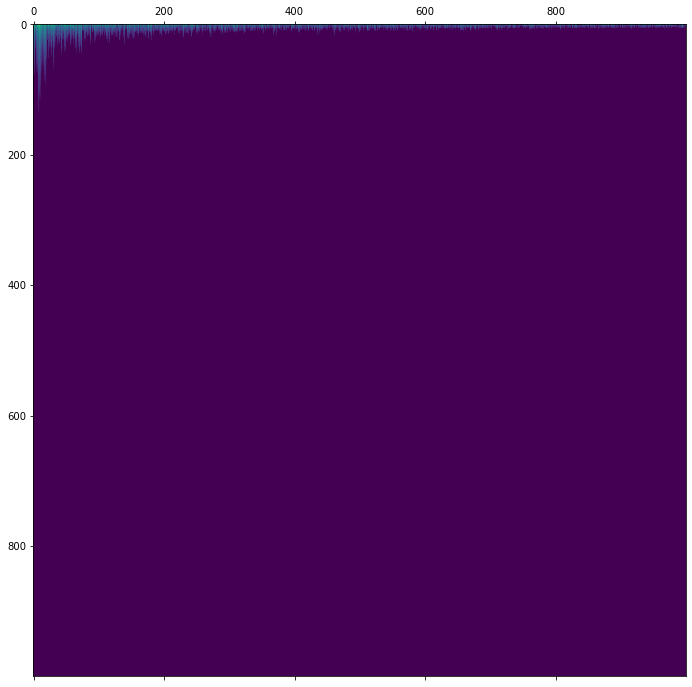

In [9]:
sorted_mat = np.sort(matrix.todense(), axis=0 )
fig, ax = plt.subplots(figsize=(12,12) )
ax.matshow(sorted_mat[::-1])
plt.show()

## Algorithm

In [10]:
system = np.zeros(size, dtype=int)
random_active = np.random.randint(0, size, n_a)
system[random_active] += 1

system, evol = GH(system, matrix, 0.1)

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

ax[0].plot(evol[:, 0], label='Refractory', color='red')
ax[0].plot(evol[:, 1], label='Inactive', color='black')
ax[0].plot(evol[:, 2], label='Active', color='blue')
ax[0].set_xlim(0, 150)
ax[0].legend()
ax[0].set_ylabel('Fraction of neurons')
ax[0].set_xlabel('Timestep')

ax[1].plot(evol[:, 2], label='Active', color='blue')
ax[1].set_xlim(50, 150)
ax[1].set_ylim(np.min(evol[50:, 2])-np.min(evol[50:, 2])/10, np.max(evol[50:, 2])+ np.max(evol[50:, 2])/10 )
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Fraction of neurons')
ax[1].set_xlabel('Timestep')

yf = fft(evol[50:,1])
ax[2].plot( np.abs(yf), color='blue', label='Active freq')
ax[2].set_ylim(0, np.max(np.abs(yf)[1:])+np.max(np.abs(yf)[1:])/10 )
ax[2].set_xlim(0, 150)
ax[2].grid()
ax[2].legend()
ax[2].set_ylabel('Fourier trasform of the fraction of neurons')
ax[2].set_xlabel('Frequency')

plt.show()

## Metrics

We will use the following metrics to analyze the results:
- Lifetime of sustained activity $\tau$. It is defined as the number of of simulation steps after whoch the activity stops, with $r_1=0$.
- Mean and standard deviation of activity fluctuation:
$$
\begin{align*}
<A>(t) &= \frac{1}{N}\sum_{i=1}^{N} \delta(s_i(t),1) \\
<A> &= \frac{1}{M}\sum_{i=1}^{M}<A>(t)\\
\sigma(A)& = \sqrt{ \frac{1}{M}\sum_{i=1}^{M}(<A>(t)-<A>)^2}
\end{align*}
$$
- the size of the second largest cluster $S_2$ of active spins.
- The correlation. Notice that to obtain a continous signal we take the convolution with a hemodynamic response function
$$
h(t)=\frac{1}{k\tau_h(k-1)!}\left(\frac{t}{\tau_h}\right)^k e^{-t/ \tau_h}
$$

In [10]:
from CriticalBrain import interevent, Correlation, linear_corr, binary_linear_corr, susceptibility

In [11]:
# Test for the susceptibility
susc_avg = []
susc_std = []
thrs = np.linspace(0.6, 1.3, 20)
nsteps = 200
n_avg = 20
for t in thrs:
    susc = []
    for i in range(n_avg):
        system = np.zeros(size, dtype=int)
        mask = np.random.choice([0, 1], size=size, p=[0.4, 0.6]).astype(np.bool)
        system[mask] += 1
        _, _, evol = GH(system, matrix, 0.1, nsteps=nsteps, time_save=True)
        susc.append( susceptibility(size, nsteps, evol, hemo_flag=True))
    susc_avg.append( np.mean(susc) )
    susc_std.append( np.std(susc) )

 16%|████████████▌                                                                    | 31/200 [00:02<00:12, 13.18it/s]


KeyboardInterrupt: 

In [ ]:
susc_avg = np.array(susc_avg)
susc_std = np.array(susc_std)
plt.plot(thrs, susc_avg, 'o--', label='average')
plt.fill_between(thrs, susc_avg+susc_std, susc_avg-susc_std, color='green', alpha=0.4, label='error')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Susceptibility')
plt.savefig('images/susc.pdf')
plt.show()

## Putting all together: Brain_simulation

In [23]:
from CriticalBrain import BrainSim

In [24]:
simulation = BrainSim(1e3, 1e1, Adj=matrix )

In [25]:
Nth = 20
thresholds = np.linspace(0.6, 1.3, Nth)

evolutions, statistics = simulation.experiment( thresholds, n_avg=20, nsteps=300)

20it [6:55:46, 1247.33s/it]


In [21]:
save = True
if save:
    simulation.save_evol('data/evol04_03_21')
    simulation.save_stats('data/stat04_03_21')

load = False
if load:
    statistics = np.loadtxt('data/stat04_03_21', skiprows=1, delimiter=',')
    thresholds = statistics[:, 1]
    statistics = statistics[:, 2:]

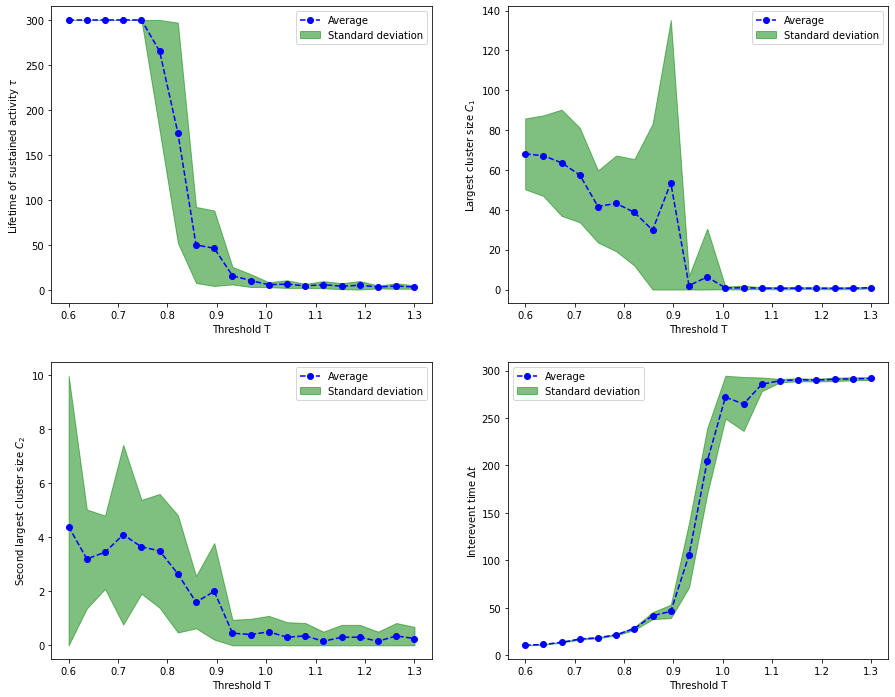

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax = ax.flatten()
i=0
ax[i].plot( thresholds, statistics[:,i], 'o--', color='blue', label='Average')
temp_plus = [ min(300, statistics[j, i]+statistics[j, i+1]) for j in range(Nth)]
temp_minu = [ max(0, statistics[j, i]-statistics[j, i+1]) for j in range(Nth)]
ax[i].fill_between( thresholds, temp_plus, temp_minu,
                color='green', alpha=0.5, label='Standard deviation')
ax[i].set_xlabel('Threshold T')
ax[i].set_ylabel('Lifetime of sustained activity $\\tau$')
ax[i].legend()

for i in range(2, 4):
    plus = [ min(300, statistics[j, i]+statistics[j, i+2]) for j in range(Nth)]
    minus = [ max(0, statistics[j, i]-statistics[j, i+2]) for j in range(Nth)]
    ax[i-1].plot( thresholds, statistics[:,i], 'o--', color='blue', label='Average')
    ax[i-1].fill_between( thresholds, plus, minus,
                       color='green', alpha=0.5, label='Standard deviation')
    ax[i-1].set_xlabel('Threshold T')
    ax[i-1].legend()
ax[1].set_ylabel('Largest cluster size $C_1$')
ax[2].set_ylabel('Second largest cluster size $C_2$')

i = 6

plus = [ min(300, statistics[j, i]+statistics[j, i+1]) for j in range(Nth)]
minus = [ max(0, statistics[j, i]-statistics[j, i+1]) for j in range(Nth)]

ax[3].plot( thresholds, statistics[:,i], 'o--', color='blue', label='Average')
ax[3].fill_between( thresholds, plus, minus,
                   color='green', alpha=0.5, label='Standard deviation')
ax[3].set_xlabel('Threshold T')
ax[3].set_ylabel('Interevent time $\\Delta t$')
ax[3].legend()

plt.savefig('images/normal.pdf')
plt.show()

In [ ]:
from CriticalBrain import Animate
evol_anim = Animate(evolutions, thresholds)
evol_anim.sys_anim(interval=500, filename='images/evol.gif')

In [21]:
act_means = np.mean(evolutions, axis=0)
mask = [ i%2==0 for i in range(2*Nth) ]

fig, ax = plt.subplots( figsize=(12, 6))
plt.plot(thresholds, act_means[mask], label='Average')
plt.fill_between( thresholds, act_means[mask]+act_means[np.logical_not(mask)], 
                 act_means[mask]-act_means[np.logical_not(mask)],
                   color='green', alpha=0.5, label='Standard deviation')
plt.legend()
plt.ylabel('Activity')
plt.xlabel('Threshold')
plt.savefig('images/Activity.pdf')

In [22]:
Corr = False
if Corr:
    fig, ax = plt.subplots(2, 2, figsize=(15, 16))
    j = 0 
    ax = ax.flatten()
    columns = ['tau', 'tau_err', 'Cl1', 'Cl2', 'Cl1_err', 'Cl2_err', 'AvgCor', 'AvgCor_err', 
                       'StdCor', 'StdCor_err', 'LinCor', 'LinCor_err', 'BinCor', 'BinCor_err', 'Interevent', 
               'Intervent_err']

    for i in range(6, 14, 2):
        ax[j].plot( thresholds, statistics[:,i], 'o--', color='blue', label='Average')
        ax[j].fill_between( thresholds, statistics[:, i]+statistics[:, i+1], statistics[:, i]-statistics[:, i+1],
                           color='green', alpha=0.5, label='Standard deviation')
        ax[j].set_xlabel('Threshold T')
        ax[j].set_title(columns[i])
        ax[j].legend()

        j += 1
    plt.show()

# Simulating attacks at criticality
Remove nodes by:
- largest degree
- largest betweeness centrality
- largest eigenvector centrality
- chosen at random

Remove links by:
- largest betweenness centrality
- links with heavyiest weight
- chosen at random

In [23]:
from CriticalBrain import attack_node, attack_link

In [24]:
# Critical threshold
Tc = [0.9]

In [25]:
# Nodes metrics
degree = np.array([ d for n, d in G.degree()] )
betw_centr = np.array( list(nx.betweenness_centrality(G).values()) )
eigv_centr = np.array( list(nx.eigenvector_centrality_numpy(G).values()) )

random = np.random.uniform(0,1, G.number_of_nodes())

In [26]:
# Links metrics
weights = np.array([ w for _, _, w in G.edges.data('weight')] )
random_edg = np.random.uniform(0,1, G.number_of_edges())

### Make experiments between 0.4-1.3

In [27]:
log_stats = {}
keys = ['degree', 'betweeness', 'eigenvector', 'random']
metrics = [degree, betw_centr, eigv_centr, random]
thresholds = np.linspace(0.4, 1.3, Nth)
nsteps = 50
for i, met in enumerate(metrics):
    damaged_graph = attack_node(G, met, nsteps=nsteps)
    new_adj = nx.adjacency_matrix( damaged_graph)

    damaged_simulation = BrainSim(1e3-nsteps, 1e1, Adj=new_adj )
    
    evolutions, statistics = damaged_simulation.experiment( thresholds, n_avg=20, nsteps=200)
    
    log_stats[keys[i]] = statistics
    
    evol_anim = Animate(evolutions, thresholds)
    evol_anim.sys_anim(interval=500, filename='images/evol_'+keys[i] +'.gif')

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
color_line = ['blue', 'red', 'black', 'green']
color_std = ['cyan', 'lightcoral', 'gainsboro', 'lime']


ax = ax.flatten()
i=0
for k in range(4): 
    ax[i].plot( thresholds,  log_stats[keys[k]][:, i], 'o--', color=color_line[k], label=keys[k])
    temp_plus = [ min(300, log_stats[keys[k]][j, i]+log_stats[keys[k]][j, i+1]) for j in range(Nth)]
    temp_minu = [ max(0, log_stats[keys[k]][j, i]-log_stats[keys[k]][j, i+1]) for j in range(Nth)]
    ax[i].fill_between( thresholds, temp_plus, temp_minu,
                    color=color_std[k], alpha=0.5)
ax[i].set_xlabel('Threshold T')
ax[i].set_ylabel('Lifetime of sustained activity $\\tau$')
ax[i].legend()

for i in range(2, 4):
    for k in range(4):
        plus = [ min(300, log_stats[keys[k]][j, i]+log_stats[keys[k]][j, i+2]) for j in range(Nth)]
        minus = [ max(0, log_stats[keys[k]][j, i]-log_stats[keys[k]][j, i+2]) for j in range(Nth)]
        
        ax[i-1].plot( thresholds,  log_stats[keys[k]][:, i], 'o--',  color=color_line[k], label=keys[k])
        ax[i-1].fill_between( thresholds, plus, minus,
                           color=color_std[k], alpha=0.5)
    ax[i-1].set_xlabel('Threshold T')
    ax[i-1].legend()
ax[1].set_ylabel('Largest cluster size $C_1$')
ax[2].set_ylabel('Second largest cluster size $C_2$')

i = 6
for k in range(4):
    plus = [ min(300, log_stats[keys[k]][j, i]+log_stats[keys[k]][j, i+1]) for j in range(Nth)]
    minus = [ max(0, log_stats[keys[k]][j, i]-log_stats[keys[k]][j, i+1]) for j in range(Nth)]
    
    ax[3].plot( thresholds, log_stats[keys[k]][:, i], 'o--',  color=color_line[k], label=keys[k])
    ax[3].fill_between( thresholds, plus, minus,
                        color=color_std[k], alpha=0.5)
ax[3].set_xlabel('Threshold T')
ax[3].set_ylabel('Interevent time $\\Delta t$')
ax[3].legend()

plt.savefig('images/damage.pdf')
plt.show()